In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from scipy import stats

In [2]:
df = pd.read_csv('/content/drive/MyDrive/winequality-white.csv', sep=';',header=0)

In [3]:
df['wine_quality'] = np.where(df['quality'] <= 4, 0 , np.where(df['quality'] <= 7, 1, 2))

In [33]:
df['wine_quality'].value_counts()

1    4535
0     183
2     180
Name: wine_quality, dtype: int64

[]

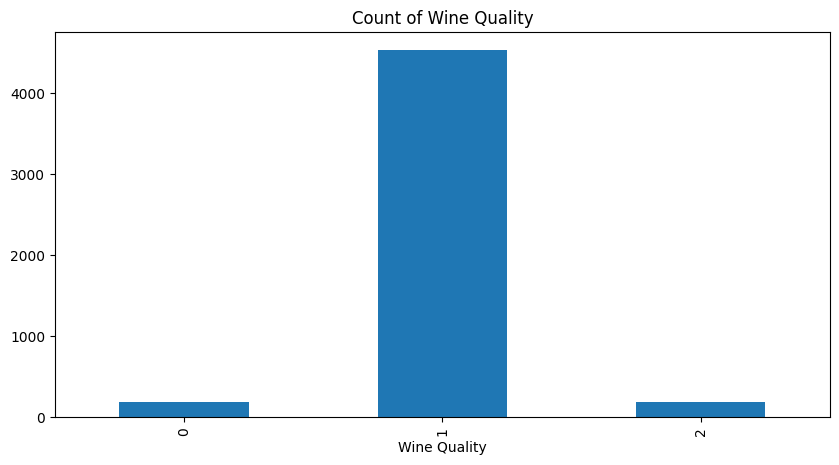

In [35]:
ax =df['wine_quality'].value_counts().sort_index().plot(kind='bar', title='Count of Wine Quality',
                                            figsize=(10,5))
ax.set_xlabel('Wine Quality')
ax.plot()

# Feature Selection (Not Used)

In [ ]:
f_scores = {}
p_values = {}


df_features = df.drop(columns=['quality','wine_quality'])

for column in df_features.columns:
    f_score, p_value = stats.f_oneway(df_features[column], df['quality'])

    f_scores[column] = f_score
    p_values[column] = p_value

In [ ]:
keys = list(f_scores.keys())
values = list(f_scores.values())

In [ ]:
test_df = pd.DataFrame({"Features":keys,"F_Score":[f"{value:.0f}" for value in values]})
test_df["P_value"] = list(p_values.values())

In [ ]:
test_df

In [ ]:
test_df['F_Score'] = pd.to_numeric(test_df['F_Score'])

In [ ]:
# for i in range(len(test_df)):
#   if test_df['F_Score'][i] < 5000:
#     df = df.drop(columns=[test_df['Features'][i]])


# Train Test Split

In [26]:
X = df.drop(['wine_quality','quality'], axis=1)
y = df['wine_quality']

In [6]:
minmax = StandardScaler()
X = minmax.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

# Random Over Sampling

In [9]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [11]:
model = XGBClassifier(n_estimators=50, max_depth=5, eta=0.1)

# Grid Search

In [12]:
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [3, 5, 7, 10],
              'eta': [0.1, 0.01, 0.001],
}
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='f1_macro')

In [13]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.1,
                                     eval_metric=None, feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_r..., max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'eta': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='f1_macro')

In [14]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'eta': 0.1, 'max_depth': 10, 'n_estimators': 150}


# Training

In [15]:
xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)

In [16]:
val_predictions = xgb_model.predict(X_val)

In [18]:
val_report = classification_report(y_val, val_predictions)
print(val_report)

              precision    recall  f1-score   support

           0       0.68      0.26      0.37        66
           1       0.94      0.99      0.96      1120
           2       0.63      0.31      0.41        39

    accuracy                           0.93      1225
   macro avg       0.75      0.52      0.58      1225
weighted avg       0.91      0.93      0.91      1225



# Results

In [19]:
predictions = xgb_model.predict(X_test)

In [21]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.25      0.38        60
           1       0.93      0.99      0.96       887
           2       0.60      0.27      0.37        33

    accuracy                           0.92       980
   macro avg       0.76      0.50      0.57       980
weighted avg       0.91      0.92      0.90       980



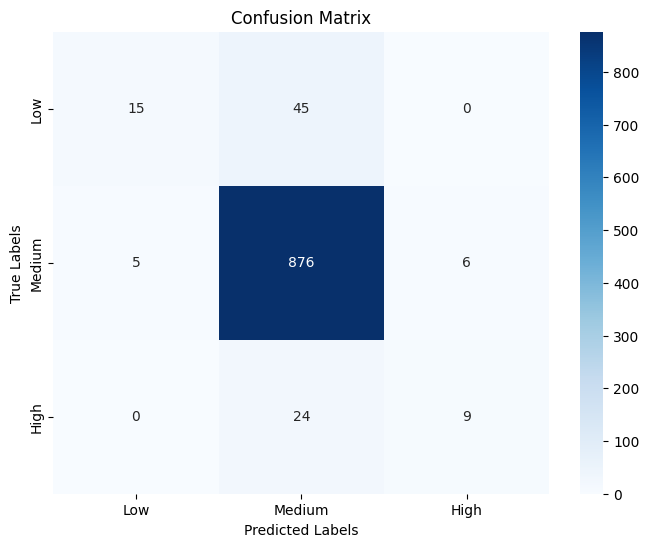

In [22]:
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
class_names = ['Low','Medium','High']
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [23]:
X_train_df = pd.DataFrame(data=X_train)

In [24]:
imp_df = pd.DataFrame({"Feature Name":X_train_df.columns,
                       "Importance":xgb_model.feature_importances_})

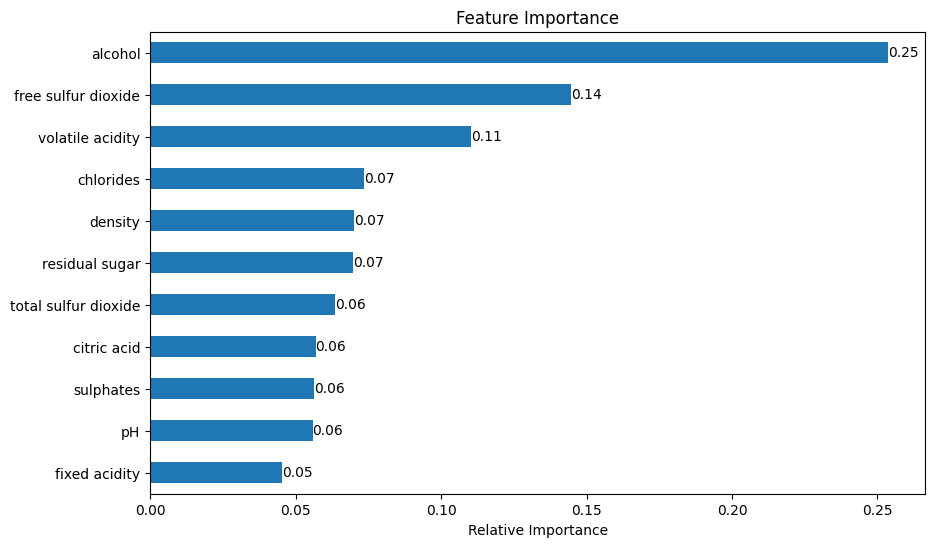

In [28]:
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
top_features = feat_importances.nlargest(11)
top_features = top_features[::-1]
top_features.plot(kind='barh')
for index, value in enumerate(top_features):
    plt.text(value, index, f'{value:.2f}', ha='left', va='center')
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.show()